In [2]:
import pandas as pd
import numpy as np
import keras
from keras import layers

In [3]:
!pip install optuna

     |████████████████████████████████| 296kB 5.3MB/s 
     |████████████████████████████████| 1.2MB 15.1MB/s 
     |████████████████████████████████| 81kB 7.4MB/s 
     |████████████████████████████████| 81kB 5.8MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
     |████████████████████████████████| 112kB 29.5MB/s 
     |████████████████████████████████| 143kB 23.0MB/s 
  Created wheel for alembic: filename=alembic-1.6.2-py2.py3-none-any.whl size=164219 sha256=47984f42ed5eb52094eecc57d67100cc108b7e08a9d5b6a6c8916e8049b3d758
  Stored in directory: /root/.cache/pip/wheels/a5/63/44/db29401e49ef5331c163b591f12a465c40af864bfa888dabd2
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11107 sha256=2017ceed2ca103facfb1356b11e9d9dc7cefd75fcf8a16be6513f784c199f154
  Stored in directory: /root/.cache/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff23be0c8c19ce4008665931ee1
Successfully built alembic pyperclip


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

import optuna

from optuna.visualization import plot_edf
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

In [5]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/Classes/BioE 145/BioE 145 Final Project'
# %cd '/content/drive/My Drive/BioE 145 Final Project'

Mounted at /content/drive
/content/drive/My Drive/Classes/BioE 145/BioE 145 Final Project


In [6]:
# REPRODUCIBILITY
SEED = 42

from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(2)

Upload the labels.csv and processed_counts.csv files to colab or your local workspace.

**Copied from Part 1:**
This data associates a cell barcode, such as "AAAGCCTGGCTAAC-1", to a certain cell type label, such as "CD14+ Monocyte". For each cell barcode, there are also log RNA seq counts of 765 different genes, such as HES4.

label.csv stores the association between a cell barcode and a cell type label.

processed_counts.csv stores the normalized log read counts for each cell, where each row represents a single cell, and each column represents a gene.

In [7]:
labels_pd = pd.read_csv("labels.csv")
counts_pd = pd.read_csv("processed_counts.csv")

In [8]:
labels_pd.index = labels_pd['index']
labels_pd.drop("index", axis=1, inplace=True)
counts_pd.index = counts_pd['Unnamed: 0']
counts_pd.drop("Unnamed: 0", axis=1, inplace=True)

df = counts_pd.merge(labels_pd, left_index=True, right_index=True).dropna()
df

,HES4,TNFRSF4,SSU72,PARK7,RBP7,SRM,MAD2L2,AGTRAP,TNFRSF1B,EFHD2,NECAP2,HP1BP3,C1QA,C1QB,HNRNPR,GALE,STMN1,CD52,FGR,ATPIF1,SESN2,EIF3I,LCK,MARCKSL1,SFPQ,PSMB2,MEAF6,NDUFS5,CAP1,SMAP2,C1orf228,PRDX1,TMEM69,SCP2,MAGOH,JAK1,CCBL2,GBP2,CD53,DENND2D,...,ZNF600,ZNF524,CTD-3138B18.5,ATP6V1E1,BID,MRPL40,UFD1L,COMT,DGCR6L,SDF2L1,IGLL5,IGLL1,CHCHD10,SMARCB1,MIF,ASCC2,PIK3IP1,HMOX1,EIF3D,IL2RB,LGALS2,EIF3L,ADSL,RBX1,TTC38,TYMP,CCT8,SOD1,PAXBP1,ATP5O,MRPS6,TTC3,U2AF1,CSTB,SUMO3,ITGB2,S100B,PRMT2,MT-ND3,bulk_labels
AAAGCCTGGCTAAC-1,-0.326,-0.191,-0.728,-0.301,3.386,-0.531,2.016,3.377,4.841,-0.525,-0.525,1.804,0.578,-0.198,1.266,-0.192,-0.307,0.048,-0.606,0.478,-0.07,-0.864,-0.534,-0.504,-0.509,-0.727,-0.646,0.336,-0.017,4.381,-0.251,0.235,-0.252,-0.701,-0.537,-0.684,-0.244,-0.421,0.575,-0.375,...,-0.109,-0.402,-0.122,-0.583,-0.690,-0.487,-0.582,-0.630,-0.507,0.697,-0.133,-0.062,1.777,0.948,0.436,-0.345,-0.418,0.652,0.351,-0.196,-0.413,-0.323,-0.491,-0.719,-0.205,-0.092,-0.694,-0.070,-0.116,-0.146,-0.532,-0.341,0.303,1.404,4.294,0.519,-0.21,-0.636,4.011,CD14+ Monocyte
AAATTCGATGCACA-1,1.171,-0.191,0.795,-1.200,-0.174,-0.531,1.889,-0.486,-0.459,-0.525,1.287,-0.420,0.954,2.367,1.170,-0.192,-0.307,0.266,0.629,-0.802,-0.07,-0.864,-0.534,0.873,-0.509,0.645,-0.646,0.274,0.856,1.845,-0.251,-0.796,-0.252,-0.701,1.581,-0.684,-0.244,-0.421,-0.282,-0.375,...,-0.109,-0.402,-0.122,-0.583,2.992,1.327,-0.582,0.991,-0.507,0.636,-0.133,-0.062,-0.687,-0.497,0.373,-0.345,-0.418,-0.366,1.496,-0.196,-0.413,0.478,-0.491,-0.719,-0.205,1.089,-0.694,-0.120,-0.116,-1.136,-0.532,-0.341,-0.905,2.849,-0.585,1.172,-0.21,2.630,-0.490,Dendritic
AACACGTGGTCTTT-1,-0.326,-0.191,0.483,-1.200,-0.174,-0.531,-0.451,0.971,-0.459,2.286,-0.525,1.258,-0.310,-0.198,-0.602,-0.192,-0.307,-0.462,1.358,-0.802,-0.07,0.205,-0.534,-0.504,-0.509,0.364,-0.646,-0.881,-0.256,-0.445,-0.251,-0.796,-0.252,0.480,2.831,1.528,-0.244,0.816,-0.440,1.583,...,-0.109,-0.402,-0.122,-0.583,-0.690,-0.487,-0.582,-0.630,-0.507,-0.502,-0.133,-0.062,-0.687,-0.497,-0.782,-0.345,-0.418,-0.366,0.037,5.397,-0.413,0.131,1.310,-0.719,-0.205,-0.733,1.747,0.428,-0.116,-1.136,2.606,-0.341,-0.905,-0.455,-0.585,0.722,-0.21,0.663,-0.490,CD56+ NK
AAGTGCACGTGCTA-1,-0.326,-0.191,1.134,-0.157,-0.174,-0.531,-0.451,-0.486,-0.459,-0.525,-0.525,9.900,-0.310,-0.198,1.565,-0.192,2.270,1.258,-0.606,-0.802,-0.07,-0.864,0.741,-0.504,2.193,2.630,1.627,-0.881,-0.990,-0.445,-0.251,-0.796,-0.252,1.114,-0.537,-0.684,-0.244,1.481,2.728,-0.375,...,-0.109,-0.402,-0.122,-0.583,-0.690,-0.487,-0.582,-0.630,-0.507,-0.502,-0.133,-0.062,-0.687,-0.497,-0.782,-0.345,-0.418,-0.366,2.036,-0.196,-0.413,-0.180,-0.491,-0.719,-0.205,-0.733,-0.694,1.221,-0.116,1.161,-0.532,-0.341,-0.905,-0.119,-0.585,0.766,-0.21,-0.636,-0.490,CD4+/CD25 T Reg
ACACGAACGGAGTG-1,-0.326,-0.191,-0.728,-0.607,-0.174,-0.531,-0.451,0.787,-0.459,1.932,-0.525,1.046,-0.310,-0.198,0.630,-0.192,-0.307,-0.546,1.110,1.730,-0.07,1.005,-0.534,-0.504,-0.509,-0.727,-0.646,-0.881,0.293,-0.445,-0.251,-0.796,-0.252,1.363,2.407,0.283,-0.244,-0.421,-0.518,-0.375,...,-0.109,-0.402,-0.122,-0.583,-0.690,-0.487,-0.582,-0.630,-0.507,-0.502,-0.133,-0.062,-0.687,-0.497,0.824,-0.345,-0.418,0.306,-0.926,-0.196,3.847,1.138,-0.491,0.213,-0.205,-0.310,-0.694,-1.048,-0.116,-1.136,0.839,1.679,-0.108,-0.534,-0.585,-0.007,-0.21,-0.636,-0.490,Dendritic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGGCACCTCCAACA-8,-0.326,-0.191,0.372,-0.584,-0.174,0.509,-0.451,2.160,-0.459,0.751,-0.525,-0.420,-0.310,0.265,-0.602,-0.192,-0.307,-1.127,-0.606,-0.802,-0.07,0.107,-0.534,2.478,-0.509,0.264,0.696,-0.881,1.676,-0.445,-0.251,-0.796,-0.252,-0.701,-0.537,1.324,-0.244,-0.421,-0.497,-0.375,...,-0.109,-0.402,-0.122,-0.583,0.639,-0.487,-0.582,-0.630,-0.507

One-hot encode the cell-type.

Shuffle your data. Make sure your labels and the counts are shuffled together.

Split into train and test sets (80:20 split)

In [9]:
df = df.rename(columns={'bulk_labels': 'cell type'})

In [10]:
## Mapping
class_map = {0: 'CD14+ Monocyte',
             1: 'Dendritic',
             2: 'CD56+ NK',
             3: 'CD4+/CD25 T Reg',
             4: 'CD19+ B',
             5: 'CD8+ Cytotoxic T',
             6: 'CD4+/CD45RO+ Memory',
             7: 'CD8+/CD45RA+ Naive Cytotoxic',
             8: 'CD4+/CD45RA+/CD25- Naive T',
             9: 'CD34+'}

In [35]:
categories = df['cell type'].unique()
print(categories)

#one-hot encoding
y = np.zeros((len(df), len(categories)))
for i in range(len(df)):
  cell_type = df.iloc[i]['cell type']
  pos = np.where(categories == cell_type)[0]
  y[i, pos] = 1

#remove label when processing input data
X = df.drop('cell type', axis=1).values

#shufle and 80:20 split
np.random.seed(100)
permutation = np.random.permutation(len(X))
X, y = X[permutation], y[permutation]

# convert to multiclass vector
y_ohe = y.copy()
y = np.argmax(y, axis=1)

X_train, y_train = X[:int(len(X)*0.8)], y[:int(len(y)*0.8)]
X_test, y_test = X[int(len(X)*0.8):], y[int(len(y)*0.8):]

['CD14+ Monocyte' 'Dendritic' 'CD56+ NK' 'CD4+/CD25 T Reg' 'CD19+ B'
 'CD8+ Cytotoxic T' 'CD4+/CD45RO+ Memory' 'CD8+/CD45RA+ Naive Cytotoxic'
 'CD4+/CD45RA+/CD25- Naive T' 'CD34+']


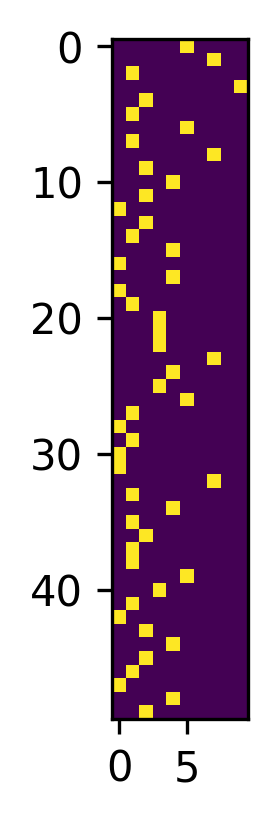

In [36]:
#Visualize the One-hot encoded Prediction Labels
import matplotlib.pyplot as plt
plt.figure(figsize=(9,3), dpi=300)
plt.imshow(y_ohe[:50]);

Apply classification algorithms to the training data, tune on validation data (if present), and evaluate on test data.

You can also apply classification downstream of last week's autoencoder latent space representation.

# Classification

## Logistic Regression

In [37]:
logistic_clf = LogisticRegression(multi_class='multinomial',
                                  max_iter = 500,
                                  random_state=SEED).fit(X_train, y_train)

train_acc = logistic_clf.score(X_train, y_train)
test_acc = logistic_clf.score(X_test, y_test)

print(train_acc)
print(test_acc)

1.0
0.8785714285714286


In [14]:
def logistic_objective(trial):
  reg_penalty = trial.suggest_categorical("regularization_type", ['l1', 
                                                                  'l2', 
                                                                  ])
  c_value = trial.suggest_loguniform("regularization_param", 1e-10, 1e10)
  classifier_obj = LogisticRegression(penalty=reg_penalty,
                                      C=c_value,
                                      solver='saga',
                                      multi_class='multinomial',
                                      max_iter=2000,
                                      random_state=SEED)

  scores = cross_val_score(classifier_obj, X_train, y_train, cv=5)
  accuracy = np.mean(scores)
  return accuracy

In [15]:
logistic_study = optuna.create_study(direction="maximize")
logistic_study.optimize(logistic_objective, n_trials=100)
print(logistic_study.best_trial)

[I 2021-05-13 23:48:43,760] A new study created in memory with name: no-name-32850142-f95d-4f45-a623-6e2ec4cfad8d
[I 2021-05-13 23:50:15,449] Trial 0 finished with value: 0.7982142857142858 and parameters: {'regularization_type': 'l2', 'regularization_param': 113881753.31691545}. Best is trial 0 with value: 0.7982142857142858.
[I 2021-05-13 23:50:16,220] Trial 1 finished with value: 0.3392857142857143 and parameters: {'regularization_type': 'l2', 'regularization_param': 3.881960511927653e-09}. Best is trial 0 with value: 0.7982142857142858.
[I 2021-05-13 23:50:16,400] Trial 2 finished with value: 0.3392857142857143 and parameters: {'regularization_type': 'l1', 'regularization_param': 8.671635888894706e-10}. Best is trial 0 with value: 0.7982142857142858.
[I 2021-05-13 23:53:18,546] Trial 3 finished with value: 0.8 and parameters: {'regularization_type': 'l1', 'regularization_param': 136.89405880190955}. Best is trial 3 with value: 0.8.
[I 2021-05-13 23:53:19,180] Trial 4 finished with 

KeyboardInterrupt: ignored

In [ ]:
print("Return a dictionary of parameter name and parameter values:",logistic_study.best_params)

In [ ]:
plot_optimization_history(logistic_study)

## Support Vector Machine

In [40]:
svc_clf = SVC(random_state=SEED).fit(X_train, y_train)

train_acc = svc_clf.score(X_train, y_train)
test_acc = svc_clf.score(X_test, y_test)

print(train_acc)
print(test_acc)

0.9857142857142858
0.7714285714285715


In [41]:
def svm_objective(trial):
  regularization_param = trial.suggest_loguniform('svc_c', 1e-10, 1e10)
  svc_kernel = trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid'])
  svc_gamma = trial.suggest_categorical("gamma", ['scale', 'auto'])
  svc_degree = trial.suggest_int('kernel_poly_degree', 3, 8)

  classifier_obj = SVC(C = regularization_param,
                       kernel=svc_kernel,
                       degree=svc_degree,
                       gamma=svc_gamma,
                       random_state=SEED)

  scores = cross_val_score(classifier_obj, X_train, y_train, cv=5)
  accuracy = np.mean(scores)
  return accuracy

In [45]:
svm_study = optuna.create_study(direction="maximize")
svm_study.optimize(svm_objective, n_trials=300)
print(svm_study.best_trial)

[I 2021-05-14 06:14:28,983] A new study created in memory with name: no-name-e5ec15b9-fe0e-4a0d-853f-5c483dfb003a
[I 2021-05-14 06:14:31,228] Trial 0 finished with value: 0.3392857142857143 and parameters: {'svc_c': 445.7429118540818, 'kernel': 'poly', 'gamma': 'scale', 'kernel_poly_degree': 8}. Best is trial 0 with value: 0.3392857142857143.
[I 2021-05-14 06:14:32,338] Trial 1 finished with value: 0.3392857142857143 and parameters: {'svc_c': 1.2703430998683352e-08, 'kernel': 'linear', 'gamma': 'auto', 'kernel_poly_degree': 5}. Best is trial 0 with value: 0.3392857142857143.
[I 2021-05-14 06:14:33,358] Trial 2 finished with value: 0.8089285714285713 and parameters: {'svc_c': 1371.4607470433841, 'kernel': 'sigmoid', 'gamma': 'auto', 'kernel_poly_degree': 7}. Best is trial 2 with value: 0.8089285714285713.
[I 2021-05-14 06:14:35,536] Trial 3 finished with value: 0.3482142857142857 and parameters: {'svc_c': 483.7115652401062, 'kernel': 'poly', 'gamma': 'auto', 'kernel_poly_degree': 4}. Be

FrozenTrial(number=92, values=[0.8196428571428571], datetime_start=datetime.datetime(2021, 5, 14, 6, 16, 25, 309964), datetime_complete=datetime.datetime(2021, 5, 14, 6, 16, 26, 439823), params={'svc_c': 0.0023573065885597096, 'kernel': 'linear', 'gamma': 'auto', 'kernel_poly_degree': 4}, distributions={'svc_c': LogUniformDistribution(high=10000000000.0, low=1e-10), 'kernel': CategoricalDistribution(choices=('linear', 'poly', 'rbf', 'sigmoid')), 'gamma': CategoricalDistribution(choices=('scale', 'auto')), 'kernel_poly_degree': IntUniformDistribution(high=8, low=3, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=92, state=TrialState.COMPLETE, value=None)


In [46]:
print("Return a dictionary of parameter name and parameter values:",svm_study.best_params)

Return a dictionary of parameter name and parameter values: {'svc_c': 0.0023573065885597096, 'kernel': 'linear', 'gamma': 'auto', 'kernel_poly_degree': 4}


In [47]:
svc_clf_tuned = SVC(C=svm_study.best_params['svc_c'],
                    kernel=svm_study.best_params['kernel'],
                    gamma=svm_study.best_params['gamma'],
                    degree=svm_study.best_params['kernel_poly_degree'],
                    random_state=SEED).fit(X_train, y_train)

train_acc = svc_clf_tuned.score(X_train, y_train)
test_acc = svc_clf_tuned.score(X_test, y_test)

print(train_acc)
print(test_acc)

0.9982142857142857
0.8714285714285714


In [49]:
plot_optimization_history(svm_study)

## Random Forest

In [52]:
rf_clf = RandomForestClassifier(random_state=SEED).fit(X_train, y_train)

train_acc = rf_clf.score(X_train, y_train)
test_acc = rf_clf.score(X_test, y_test)

print(train_acc)
print(test_acc)

1.0
0.8214285714285714


In [79]:
def rf_objective(trial):
  n_estimators = trial.suggest_int('n_estimators', 20, 250, 5)
  max_depth = trial.suggest_int("max_depth", 6, 30)
  max_features = trial.suggest_categorical("max_features", ['auto', 'sqrt', 'log2'])
  min_samples_split = trial.suggest_int("min_samples_split", 2, 5)
  min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)

  classifier_obj = RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          max_features=max_features,
                                          min_samples_split=min_samples_split,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=SEED)

  scores = cross_val_score(classifier_obj, X_train, y_train, cv=5)
  accuracy = np.mean(scores)
  return accuracy

In [80]:
rf_study = optuna.create_study(direction="maximize")
rf_study.optimize(rf_objective, n_trials=300)
print(rf_study.best_trial)

[I 2021-05-14 07:03:01,035] A new study created in memory with name: no-name-67449556-b30c-4db4-bd41-6d8519a7d5a2
[I 2021-05-14 07:03:01,512] Trial 0 finished with value: 0.7714285714285715 and parameters: {'n_estimators': 45, 'max_depth': 8, 'max_features': 'log2', 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.7714285714285715.
[I 2021-05-14 07:03:05,190] Trial 1 finished with value: 0.7892857142857143 and parameters: {'n_estimators': 225, 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.7892857142857143.
[I 2021-05-14 07:03:05,757] Trial 2 finished with value: 0.7910714285714286 and parameters: {'n_estimators': 35, 'max_depth': 21, 'max_features': 'auto', 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.7910714285714286.
[I 2021-05-14 07:03:06,799] Trial 3 finished with value: 0.775 and parameters: {'n_estimators': 105, 'max_depth': 12, 'max_features': 'l

FrozenTrial(number=258, values=[0.8035714285714286], datetime_start=datetime.datetime(2021, 5, 14, 7, 8, 18, 322144), datetime_complete=datetime.datetime(2021, 5, 14, 7, 8, 19, 251943), params={'n_estimators': 55, 'max_depth': 18, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 1}, distributions={'n_estimators': IntUniformDistribution(high=250, low=20, step=5), 'max_depth': IntUniformDistribution(high=30, low=6, step=1), 'max_features': CategoricalDistribution(choices=('auto', 'sqrt', 'log2')), 'min_samples_split': IntUniformDistribution(high=5, low=2, step=1), 'min_samples_leaf': IntUniformDistribution(high=4, low=1, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=258, state=TrialState.COMPLETE, value=None)


In [81]:
print("Return a dictionary of parameter name and parameter values:",rf_study.best_params)

Return a dictionary of parameter name and parameter values: {'n_estimators': 55, 'max_depth': 18, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 1}


In [82]:
rf_clf_tuned = RandomForestClassifier(n_estimators=rf_study.best_params['n_estimators'],
                                      max_depth=rf_study.best_params['max_depth'],
                                      max_features=rf_study.best_params['max_features'],
                                      min_samples_split=rf_study.best_params['min_samples_split'],
                                      min_samples_leaf=rf_study.best_params['min_samples_leaf'],
                                      random_state=SEED).fit(X_train, y_train)

train_acc = rf_clf_tuned.score(X_train, y_train)
test_acc = rf_clf_tuned.score(X_test, y_test)

print(train_acc)
print(test_acc)

0.9982142857142857
0.8


In [83]:
plot_optimization_history(rf_study)

## AdaBoost

In [373]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

logreg = LogisticRegression(C = 1.0, max_iter= 10000000,
                            penalty = 'l2', solver = 'lbfgs', multi_class = 'multinomial')

ada_clf = AdaBoostClassifier(logreg, n_estimators=100, learning_rate =  0.00001, random_state=10)
ada_clf.fit(X_train, y_train)

# ada_clf.predict(y_test)
ada_clf.score(X_test, y_test)

0.8285714285714286

## Neural Network

In [13]:
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from tensorflow.keras.layers import Dropout

In [359]:
## Back to OHE form for NN
X_train, y_train = X[:int(len(X)*0.8)], y_ohe[:int(len(y)*0.8)]
X_test, y_test = X[int(len(X)*0.8):], y_ohe[int(len(y)*0.8):]

In [360]:
"""
Uncomment to create the 2x data
"""
# X_train = np.concatenate((X_train, X_train), axis=0)
# y_train = np.concatenate((y_train, y_train), axis=0)

In [361]:
input_dim = X_train.shape[1]

model = Sequential()
model.add(tf.keras.Input(shape=input_dim,))
model.add(Dense(128, activation='relu', 
                activity_regularizer=regularizers.l1(10e-4)
                ))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu',
                activity_regularizer=regularizers.l1(10e-4),
                ))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_207 (Dense)            (None, 128)               98048     
_________________________________________________________________
dropout_140 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_208 (Dense)            (None, 32)                4128      
_________________________________________________________________
dropout_141 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_209 (Dense)            (None, 10)                330       
Total params: 102,506
Trainable params: 102,506
Non-trainable params: 0
_________________________________________________________________


In [362]:
num_epochs = 500
BATCH_SIZE = 256
VAL_SIZE = 0.1 # small validation size to maximize small dataset
LEARNING_RATE = 0.0003

optimizer = Adam(lr=LEARNING_RATE)
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizer, metrics=['accuracy'])

# REPRODUCIBILITY
seed(1)
tf.random.set_seed(2)

history = model.fit(X_train, 
                    y_train, 
                    epochs=num_epochs,
                    batch_size=BATCH_SIZE,
                    validation_split=VAL_SIZE)

Epoch 1/500
4/4 [==============================] - 1s 99ms/step - loss: 3.6120 - accuracy: 0.1461 - val_loss: 2.3036 - val_accuracy: 0.2321
Epoch 2/500
4/4 [==============================] - 0s 23ms/step - loss: 3.2424 - accuracy: 0.1712 - val_loss: 2.0585 - val_accuracy: 0.3571
Epoch 3/500
4/4 [==============================] - 0s 23ms/step - loss: 2.9202 - accuracy: 0.2361 - val_loss: 1.8489 - val_accuracy: 0.4286
Epoch 4/500
4/4 [==============================] - 0s 27ms/step - loss: 2.7485 - accuracy: 0.2745 - val_loss: 1.6785 - val_accuracy: 0.5000
Epoch 5/500
4/4 [==============================] - 0s 21ms/step - loss: 2.5452 - accuracy: 0.2748 - val_loss: 1.5418 - val_accuracy: 0.5446
Epoch 6/500
4/4 [==============================] - 0s 25ms/step - loss: 2.3268 - accuracy: 0.3273 - val_loss: 1.4299 - val_accuracy: 0.5714
Epoch 7/500
4/4 [==============================] - 0s 22ms/step - loss: 2.1039 - accuracy: 0.3733 - val_loss: 1.3400 - val_accuracy: 0.6161
Epoch 8/500
4/4 [===

In [363]:
y_test_hat = np.argmax(model.predict(X_test), axis=1)
y_test_true = np.argmax(y_test, axis=1)

test_acc = sum(y_test_hat == y_test_true) / len(y_test_true)

print(test_acc)

0.8857142857142857


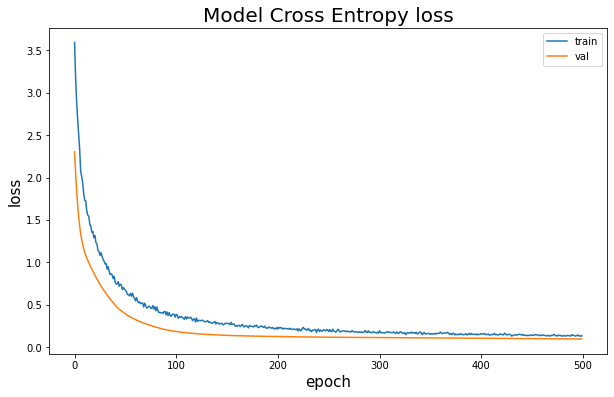

In [374]:
## Plot Accuracy and Loss over Time
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Cross Entropy loss', fontsize=20)
plt.ylabel('loss', fontsize=15)
plt.xlabel('epoch', fontsize=15)
plt.legend(['train', 'val'], loc='upper right')
plt.show()  

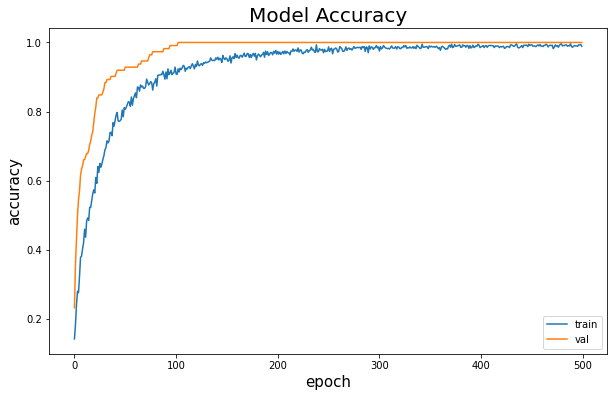

In [375]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy', fontsize=20)
plt.ylabel('accuracy', fontsize=15)
plt.xlabel('epoch', fontsize=15)
plt.legend(['train', 'val'], loc='lower right')
plt.show()

# Model Analysis

## Confusion Matrices for predictions across 10 classes

In [366]:
X_train, y_train = X[:int(len(X)*0.8)], y[:int(len(y)*0.8)]
X_test, y_test = X[int(len(X)*0.8):], y[int(len(y)*0.8):]

In [367]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm_df = pd.DataFrame(confusion_matrix(y_test, y_test_hat))
cm_df.columns = [class_map[col] for col in cm_df.columns]
cm_df = cm_df.rename(index=class_map)

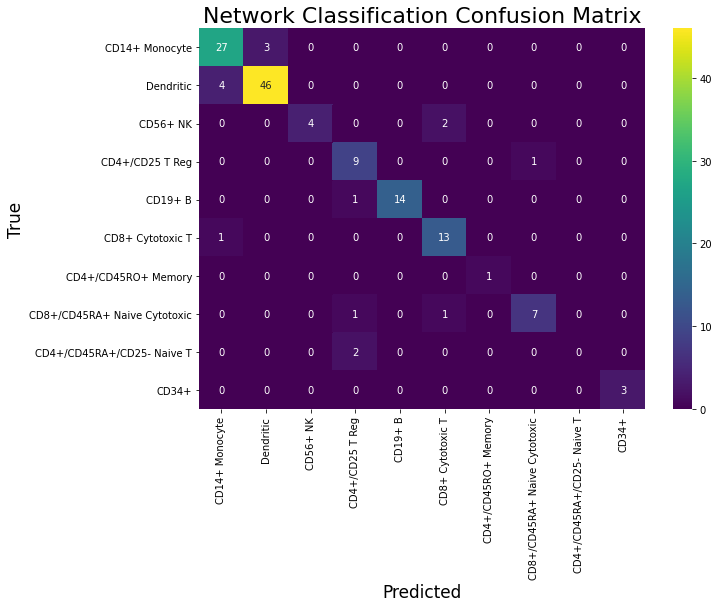

In [377]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, cmap="viridis")
plt.title('Network Classification Confusion Matrix', fontsize=22)
plt.xlabel('Predicted', fontsize=17);
plt.ylabel('True', fontsize=17);

## Class Imbalance

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



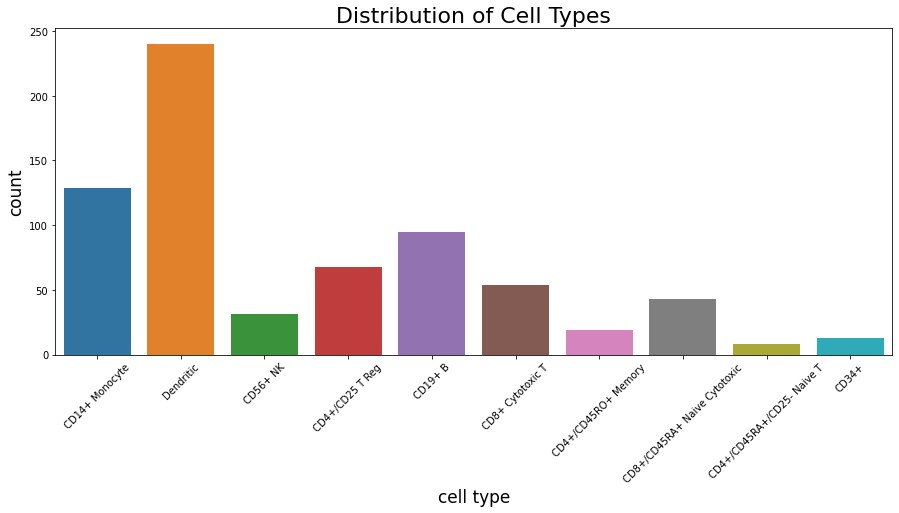

In [392]:
# Plot of Class Imbalance
plt.figure(figsize=(15, 6))
sns.countplot(df['cell type']);
plt.xticks(rotation = 45);
plt.title('Distribution of Cell Types', fontsize=22);
plt.xlabel('cell type', fontsize=17);
plt.ylabel('count', fontsize=17);